In [1]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("allenai/WildChat-4.8M")


c:\Microsoft VS Code\VsCodeProject\Prof.Yu\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets import load_dataset  
print(ds["train"].features) 
print(ds["train"].column_names)

{'conversation_hash': Value('string'), 'model': Value('string'), 'timestamp': Value('timestamp[us]'), 'conversation': List({'content': Value('string'), 'created': Value('int64'), 'header': {'accept-language': Value('string'), 'user-agent': Value('string')}, 'hashed_ip': Value('string'), 'country': Value('string'), 'toxic': Value('bool'), 'redacted': Value('bool'), 'state': Value('string'), 'language': Value('string'), 'openai_id': Value('string'), 'role': Value('string'), 'temperature': Value('float64'), 'timestamp': Value('timestamp[us]'), 'token_counter': Value('int64'), 'top_p': Value('float64'), 'turn_identifier': Value('int64'), 'system_fingerprint': Value('string'), 'usage': {'completion_tokens': Value('int64'), 'completion_tokens_details': {'reasoning_tokens': Value('int64'), 'text_tokens': Value('int64'), 'audio_tokens': Value('int64'), 'accepted_prediction_tokens': Value('int64'), 'rejected_prediction_tokens': Value('int64')}, 'prompt_tokens': Value('int64'), 'total_tokens': V

## 1. only "english" and filter out those data without content including "literature review"

In [ ]:
from datasets import load_dataset

train = ds["train"]

def is_english(example):
    lang = example.get("language") or ""
    return isinstance(lang, str) and lang.lower() == "english"

def contains_lit_review(example):
    conv = example.get("conversation") or example.get("conversations") or []
    if isinstance(conv, dict):
        content = conv.get("content") or conv.get("text") or ""
        return isinstance(content, str) and "literature review" in content.lower()
    for msg in conv:
        if isinstance(msg, str):
            if "literature review" in msg.lower():
                return True
        if isinstance(msg, dict):
            content = msg.get("content")
            if isinstance(content, str) and "literature review" in content.lower():
                return True
    return False

english_ds = train.filter(is_english)

result_ds = english_ds.filter(contains_lit_review)

print("matches:", result_ds.num_rows)
print(result_ds[:5]) 

Filter: 100%|██████████| 1679371/1679371 [16:04<00:00, 1740.79 examples/s]

matches: 2828
{'conversation_hash': ['f119a9facac0b73768ba222235191e8c', '244ca4d4c25048eab5ffd2143674c962', '97c0cfb2b2c0927430663d94cc224671', '6bf9bc2150bf25b1454bc908b7d0656c', 'f1efddaa90a0acf0674ce2ce0a9a9d8f'], 'model': ['gpt-4-0314', 'gpt-4-0314', 'gpt-4-0314', 'gpt-4-0314', 'gpt-4-0314'], 'timestamp': [datetime.datetime(2023, 4, 9, 1, 42, 3), datetime.datetime(2023, 4, 9, 3, 40, 40), datetime.datetime(2023, 4, 9, 3, 58, 26), datetime.datetime(2023, 4, 9, 5, 38, 2), datetime.datetime(2023, 4, 9, 5, 42, 3)], 'conversation': [[{'content': 'I would liketo be a researcher of artificial intelligence (architecture) and an architectural teacher, requiringyou tostudya given topic, develop thesisstatements,and createconvincing documentsthatareboth informative and innovative, while offering assistance toarchitectsandarchitectswhoneedto improve their writing, and you will beresponsible for providing feedback to architects and architectsusingartificial intelligence toolssuch as natural lan

In [18]:
# 查看整体 schema 和字段名
print(ds)                       # DatasetDict 信息
print(ds["train"].features)     # 每个字段的 Feature 类型（Sequence, Value, dict 等）
print(ds["train"].column_names) # 列名列表

# 查看第一条样本的 conversation 字段和类型
sample = ds["train"][0]
print(type(sample.get("conversation")), sample.get("conversation"))

DatasetDict({
    train: Dataset({
        features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header'],
        num_rows: 3199860
    })
})
{'conversation_hash': Value('string'), 'model': Value('string'), 'timestamp': Value('timestamp[us]'), 'conversation': List({'content': Value('string'), 'created': Value('int64'), 'header': {'accept-language': Value('string'), 'user-agent': Value('string')}, 'hashed_ip': Value('string'), 'country': Value('string'), 'toxic': Value('bool'), 'redacted': Value('bool'), 'state': Value('string'), 'language': Value('string'), 'openai_id': Value('string'), 'role': Value('string'), 'temperature': Value('float64'), 'timestamp': Value('timestamp[us]'), 'token_counter': Value('int64'), 'top_p': Value('float64'), 'turn_identifier': Value('int64'), 'system_fingerprint': Value('string'), 'usage': {'completion_tokens': Value('int

columns: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']


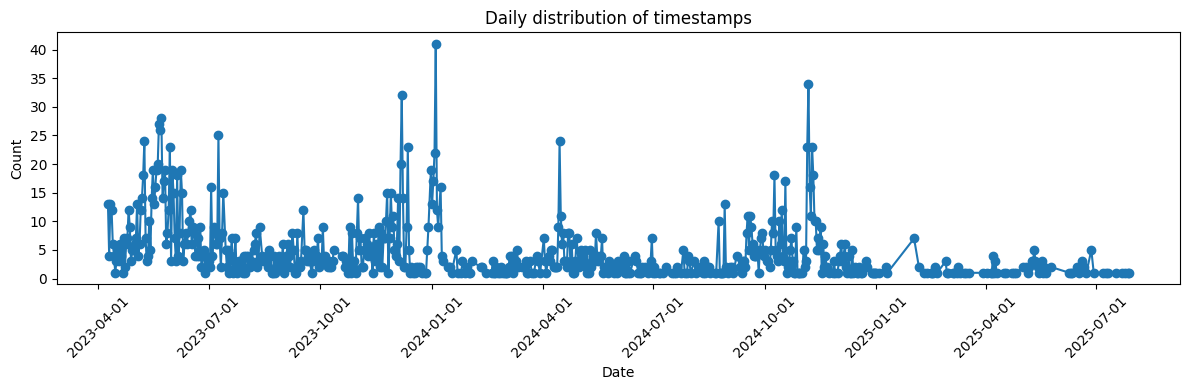

In [ ]:
# 不使用 to_pandas()，支持 datetime / 数值 epoch / 字符串 / 列表情况
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 更强的字符串解析（可选）
try:
    from dateutil import parser as _dateutil_parser
except Exception:
    _dateutil_parser = None

ts_col = "timestamp"   # 若列名不同请修改
batch_size = 10000     # 根据内存和数据量调整

def as_datetime(v):
    if v is None:
        return None
    if isinstance(v, datetime):
        return v
    if isinstance(v, (int, float)):
        return datetime.fromtimestamp(v/1000.0) if abs(v) > 1e11 else datetime.fromtimestamp(v)
    if isinstance(v, str):
        try:
            return datetime.fromisoformat(v)
        except Exception:
            if _dateutil_parser:
                try:
                    return _dateutil_parser.parse(v)
                except Exception:
                    return None
            return None
    return None

# 检查列存在

print("columns:", result_ds.column_names)
assert ts_col in result_ds.column_names, f"找不到列 {ts_col}"

counter = Counter()
n = len(result_ds)
for start in range(0, n, batch_size):
    end = min(n, start + batch_size)
    batch = result_ds[start:end]
    vals = batch[ts_col]
    for v in vals:
        # 支持单个 datetime 或列表/元组
        if isinstance(v, (list, tuple)):
            for sub in v:
                dt = as_datetime(sub)
                if dt:
                    counter[dt.date()] += 1
        else:
            dt = as_datetime(v)
            if dt:
                counter[dt.date()] += 1

if not counter:
    raise RuntimeError("未解析到有效时间，请检查时间列格式或列名")

dates_sorted = sorted(counter.keys())
counts = [counter[d] for d in dates_sorted]

plt.figure(figsize=(12,4))
plt.plot(dates_sorted, counts, marker='o', linestyle='-')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily distribution of timestamps')
plt.tight_layout()
plt.show()

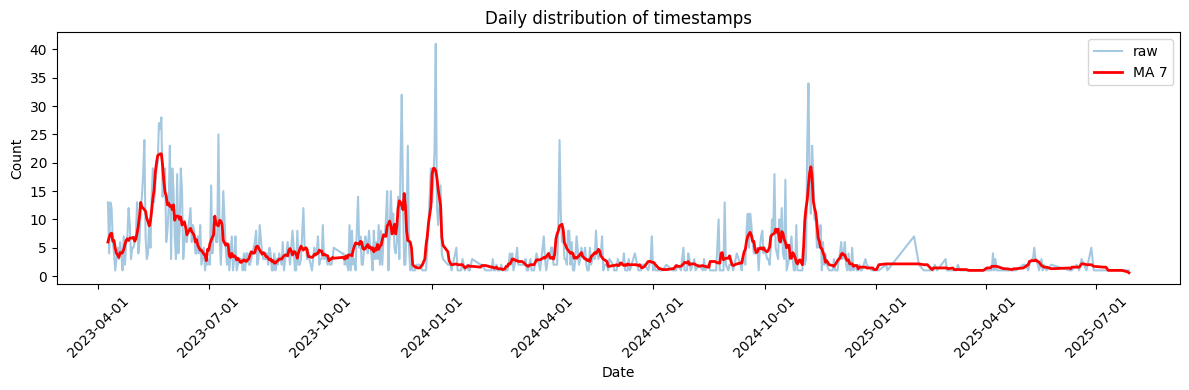

In [16]:
# Simple moving average
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def moving_average(y, window):
    kernel = np.ones(window) / window
    return np.convolve(y, kernel, mode="same")

window = 7   # 改成 7 / 14 / 30 等
smoothed = moving_average(counts, window)

plt.figure(figsize=(12,4))
plt.plot(dates_sorted, counts, alpha=0.4, label="raw")
plt.plot(dates_sorted, smoothed, color="red", linewidth=2, label=f"MA {window}")
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45); plt.legend()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily distribution of timestamps')
plt.tight_layout()
plt.show()

In [17]:
# 不使用 to_pandas()，支持 datetime / 数值 epoch / 字符串 / 列表情况
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 更强的字符串解析（可选）
try:
    from dateutil import parser as _dateutil_parser
except Exception:
    _dateutil_parser = None

ts_col = "timestamp"   # 若列名不同请修改
batch_size = 10000     # 根据内存和数据量调整

def as_datetime(v):
    if v is None:
        return None
    if isinstance(v, datetime):
        return v
    if isinstance(v, (int, float)):
        return datetime.fromtimestamp(v/1000.0) if abs(v) > 1e11 else datetime.fromtimestamp(v)
    if isinstance(v, str):
        try:
            return datetime.fromisoformat(v)
        except Exception:
            if _dateutil_parser:
                try:
                    return _dateutil_parser.parse(v)
                except Exception:
                    return None
            return None
    return None

# 检查列存在

print("columns:", train.column_names)
assert ts_col in train.column_names, f"找不到列 {ts_col}"

counter_all = Counter()
n = len(train)
for start in range(0, n, batch_size):
    end = min(n, start + batch_size)
    batch = train[start:end]
    vals = batch[ts_col]
    for v in vals:
        # 支持单个 datetime 或列表/元组
        if isinstance(v, (list, tuple)):
            for sub in v:
                dt = as_datetime(sub)
                if dt:
                    counter_all[dt.date()] += 1
        else:
            dt = as_datetime(v)
            if dt:
                counter_all[dt.date()] += 1

if not counter_all:
    raise RuntimeError("未解析到有效时间，请检查时间列格式或列名")

dates_sorted_all = sorted(counter_all.keys())
counts_all = [counter_all[d] for d in dates_sorted_all]

plt.figure(figsize=(12,4))
plt.plot(dates_sorted_all, counts_all, marker='o', linestyle='-')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily distribution of all timestamps')
plt.tight_layout()
plt.show()

columns: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']


KeyboardInterrupt: 